# Water Risk Classification: Data Wrangling

## Setup

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import requests, zipfile, io, os, tarfile

import rasterio as rio
from rasterio import plot
from rasterstats import zonal_stats
import rasterio.warp, rasterio.shutil
import rioxarray # for the extension to load
import xarray
import missingno as msno
from shapely.geometry import Polygon

from matplotlib import pyplot
import folium
from matplotlib import pyplot as plt
%matplotlib inline


## Download Data
**ONLY RUN IF YOU DON'T HAVE THE DATA FOLDER YET. IT WILL TAKE A LONG TIME.**

Download and unzip all the datasets. 

In [2]:
# create data folder
os.mkdir('./data')

### Aqueduct Database

In [4]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_aq = 'https://wri-projects.s3.amazonaws.com/Aqueduct30/finalData/Y2019M07D12_Aqueduct30_V01.zip'

r = requests.get(url_aq) # download zipped directory
z = zipfile.ZipFile(io.BytesIO(r.content)) # create zipfile object
z.extractall(path='data') # unzip into data subdirectory

### Global Human Settlments Layer

In [5]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_ghs = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_MT_GLOBE_R2019A/GHS_POP_E2015_GLOBE_R2019A_54009_1K/V1-0/GHS_POP_E2015_GLOBE_R2019A_54009_1K_V1_0.zip'

r = requests.get(url_ghs) # download zipped directory
z = zipfile.ZipFile(io.BytesIO(r.content)) # create zipfile object
z.extractall(path='data/ghs') # unzip into data subdirectory

### Infant  Mortality

The SEDAC infant mortality data requires user authentication so we did not download if programatically. The data is available for download [here](https://sedac.ciesin.columbia.edu/downloads/data/povmap/povmap-global-subnational-infant-mortality-rates-v2/povmap-global-subnational-infant-mortality-rates-v2-geotiff.zip) and is unzipped to `./data/sedac/`.

In [10]:
# This download requires useer authentication and isn't currently working
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_inf_mort = 'https://sedac.ciesin.columbia.edu/downloads/data/povmap/povmap-global-subnational-infant-mortality-rates-v2/povmap-global-subnational-infant-mortality-rates-v2-geotiff.zip'

r = requests.get(url_inf_mort) # download zipped directory
z = zipfile.ZipFile("./data/povmap-global-subnational-infant-mortality-rates-v2-geotiff.zip") # create zipfile object
z.extractall(path='./data/sedac') # unzip into data subdirectory
z.close()

### Nighttime Light

In [34]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_light = 'https://ngdc.noaa.gov/eog/data/web_data/v4avg_lights_x_pct/F182013.v4c.avg_lights_x_pct.tgz'

r = requests.get(url_light, allow_redirects=True)
open('./data/F182013.v4c.avg_lights_x_pct.tgz', 'wb').write(r.content)

KeyboardInterrupt: 

In [38]:
temp_path = './data/F182013.v4c.avg_lights_x_pct.tgz'

z = tarfile.open(temp_path, mode='r:gz') # create zipfile object
z.extractall(path='data/light') # unzip into data subdirectory
z.close()

os.remove(temp_path)

## Load Data

WRI Aqueduct metadata with column name explanations is available [here](https://github.com/wri/aqueduct30_data_download/blob/master/metadata.md).

In [3]:
path_aq = './data/Y2019M07D12_Aqueduct30_V01/baseline/annual/y2019m07d11_aqueduct30_annual_v01.gpkg'

aq = gpd.read_file(path_aq, layer='y2019m07d11_aqueduct30_annual_v01')

In [4]:
# Select just the columns that will be used for the analysis
data_cols = ['string_id', 'geometry','bws_raw', 'bwd_raw', 'iav_raw', 'sev_raw', 'gtd_raw', 'rfr_raw', 'cfr_raw', 'drr_raw', 'ucw_raw', 'udw_raw', 'usa_raw']

data = aq.loc[aq['gid_0'] != 'GRL'].copy()
data = data.loc[data['gid_0'].notnull()]
data = data[data_cols].copy()
data.shape

(57363, 13)

In [ ]:
path_ghs = './data/ghs/GHS_POP_E2015_GLOBE_R2019A_54009_1K_V1_0.tif'

ghs_meta = None
ghs_t = None
with rio.open(path_ghs) as tif:
    ghs_meta = tif.meta
    ghs_t = ghs.transform
    oviews = tif.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[-1]
    thumbnail = tif.read(1, out_shape=(1, int(tif.height // oview), int(tif.width // oview)))

In [40]:
ghs_meta['width'], ghs_meta['height'], ghs_meta['width']*ghs_meta['height']

(36082, 18000, 649476000)

In [6]:
path_inf_mort = './data/sedac/povmap_global_subnational_infant_mortality_rates_v2.tif'

with rio.open(path_inf_mort) as tif:
    inf_mort = tif

In [7]:
path_light = './data/light/F182013.v4c.avg_lights_x_pct.tif'

with rio.open(path_light) as tif:
    light = rio.open(tif)


## Explore Data

In [ ]:
with rio.open(path_ghs) as im:
    rio.plot.show_hist(im, bins=50, lw=0.0, stacked=False, alpha=1, histtype='stepfilled', title="Population")

In [8]:
ghs.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -200.0,
 'width': 36082,
 'height': 18000,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]'),
 'transform': Affine(1000.0, 0.0, -18041000.0,
        0.0, -1000.0, 9000000.0)}

In [ ]:
# plot of infant mortality
with rio.open(path_inf_mort) as im:
    rio.plot.show_hist(im, bins=50, lw=0.0, stacked=False, alpha=1, histtype='stepfilled', title="Infant Mortality")

In [62]:
inf_mort.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -1.7976931348623157e+308,
 'width': 43200,
 'height': 17173,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:4326'),
 'transform': Affine(0.00833333333333333, 0.0, -179.99999999999997,
        0.0, -0.00833333333333333, 83.62711161733333)}

In [ ]:
# Plot of light
# plot of infant mortality
with rio.open(path_inf_mort) as im:
    rio.plot.show_hist(im, bins=50, lw=0.0, stacked=False, alpha=1, histtype='stepfilled', title="Nightime Light")

In [63]:
light.meta,plot

({'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': None,
  'width': 43201,
  'height': 16801,
  'count': 1,
  'crs': CRS.from_dict(init='epsg:4326'),
  'transform': Affine(0.0083333333, 0.0, -180.00416666665,
         0.0, -0.0083333333, 75.00416666665)},
 <module 'rasterio.plot' from '/Users/johnmichaellasalle/anaconda3/envs/wrc/lib/python3.7/site-packages/rasterio/plot.py'>)

In [64]:
# check crs
aq.crs == ghs.crs, aq.crs == inf_mort.crs, aq.crs == light.crs

({'init': 'epsg:4326'}, False, True, True)

## Join Data

In [43]:
with rio.open(path_inf_mort) as inf_mort:
    inf_mort_array = inf_mort.read(1)

In [44]:
# Reclassify from two values for no data to just one
inf_mort_array[inf_mort_array<0] = -999

In [45]:
# Need to set nodata value explicitly
mortality_stats = zonal_stats(data, inf_mort_array, 
                              affine = inf_mort.transform, 
                              stats = ['mean', 'median'],
                              nodata = -999)

In [46]:
data['mean_infant_mort'] = [s['mean'] for s in mortality_stats]
#aq_join['median_infant_mort'] = [t['median'] for t in mortality_stats]

# aq_join.loc[np.isinf(aq_join['mean_infant_mort']) == True, 'mean_infant_mort'] = float('NaN')
# aq_join.loc[np.isinf(aq_join['median_infant_mort']) == True, 'median_infant_mort'] = float('NaN')
# aq_join.loc[np.isinf(aq_join['sum_infant_mort']) == True, 'sum_infant_mort'] = float('NaN')

In [47]:
with rio.open(path_light) as light:
    light_array = light.read(1)

In [48]:
light_stats = zonal_stats(data, light_array, 
                          affine = light.transform, 
                          stats = ['mean'],
                          nodata = -999)

In [49]:
data['mean_light'] = [s['mean'] for s in light_stats]

data.loc[np.isnan(data['mean_light']) == True, 'mean_light'] = 0

In [50]:
with rio.open(path_ghs) as ghs:
    ghs_array = ghs.read(1)

In [51]:
ghs_stats = zonal_stats(data.to_crs(ghs.crs.data), ghs_array, 
                        affine = ghs.transform, 
                        stats = ['sum'],
                        nodata = -200.0)

In [52]:
data['sum_pop'] = [u['sum'] for u in ghs_stats]

In [53]:
data['sum_pop'].isna().sum()

s = data.loc[data['sum_pop'] < 0]
t = data.loc[np.isnan(data['sum_pop'])]

s.shape, t.shape

((0, 16), (2459, 16))

## Engineer Features

In [55]:
# Calculate the area of each Aqueduct polygon
# project to equal area projection to calculate densities
# NSIDC EASE-Grid 2.0 Global Equal area to calculate densities, https://epsg.io/6933

data['area_sqkm'] = data.to_crs({'init':'epsg:6933'}).area/10000000

# Calculate population density
data['pop_density'] = data['sum_pop']/data['area_sqkm']

# reclassify NAs as zero
data.loc[np.isnan(data['pop_density']) == True, 'pop_density'] = 0

In [56]:
data.sum_pop.min()

0.0

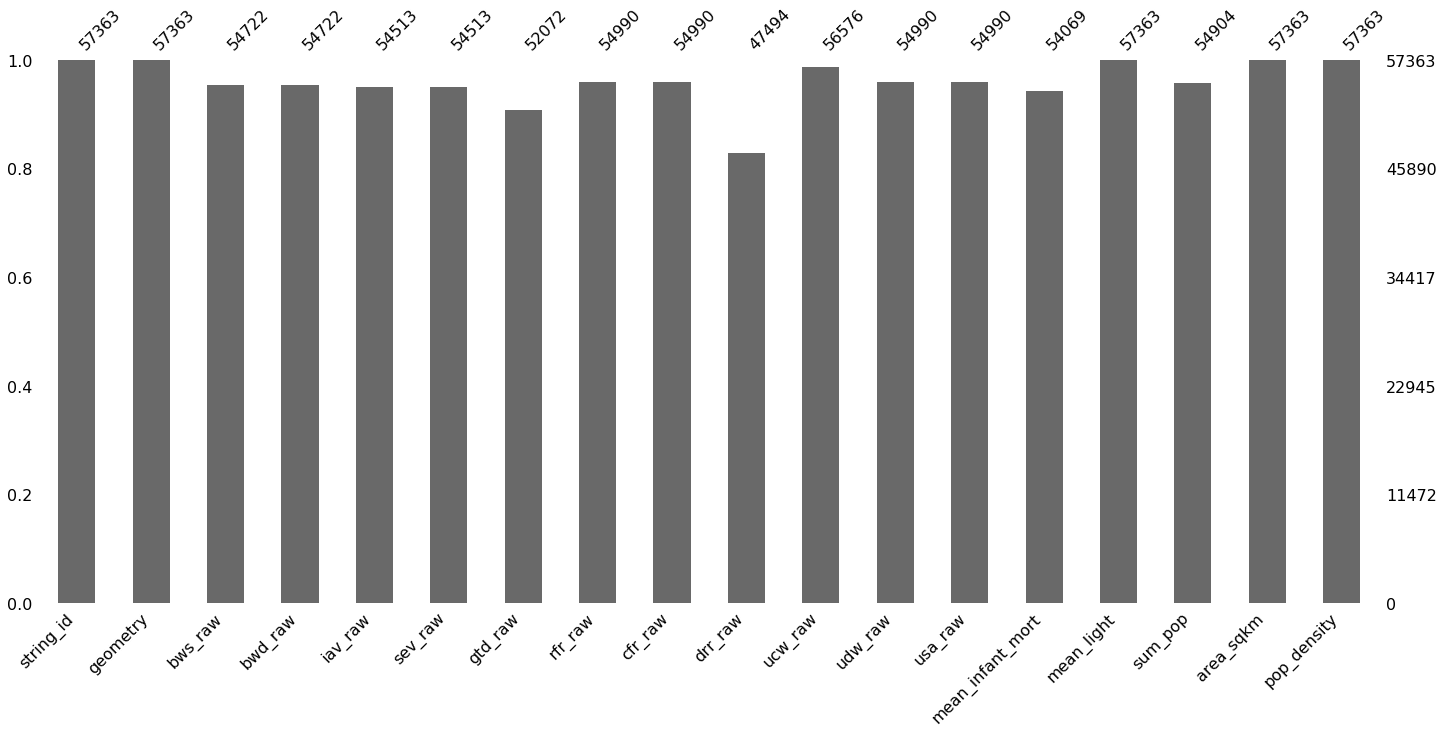

In [57]:
msno.bar(data)

## Save GeoJSON for Modeling

In [59]:
export_cols = ['string_id', 'geometry', 'bws_raw', 'bwd_raw', 'iav_raw', 'sev_raw', 'gtd_raw', 'rfr_raw', 'cfr_raw', 
               'drr_raw', 'ucw_raw', 'udw_raw', 'usa_raw',
               'mean_infant_mort', 'mean_light', 'pop_density'
              ]
# select columns to export and project back to WGS84
data_export = data[export_cols].to_crs(aq.crs)

In [60]:
# Save data
data_export.to_file("./data/data.geojson", driver='GeoJSON')